# construct mock0

In [1]:
import os
import numpy as np 

In [2]:
from astropy import units as u
from astropy.cosmology import Planck13

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read noiseless data

In [4]:
mock = np.load('/Users/chahah/data/binsin/sample_UVLF_1pointingCEERS.npy')

(-14.0, -22.0)

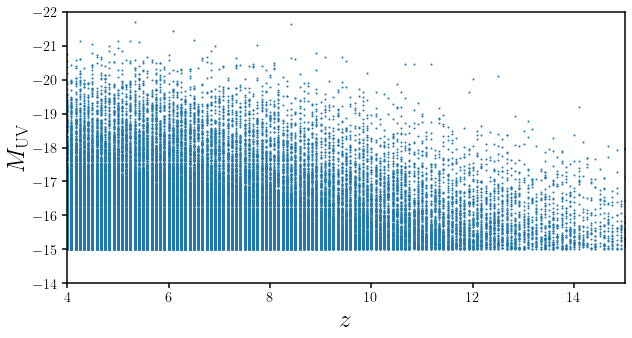

In [5]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## implement $z$ selection function
This is supposedly from simulations.

In [6]:
prob_z = np.exp(-(mock[:,0] - 9.0)**2)
select_z = prob_z > np.random.uniform(size=mock.shape[0])
print(np.mean(select_z))
print(np.sum(select_z))

0.13935282605176802
9470


(0.0, 1.1)

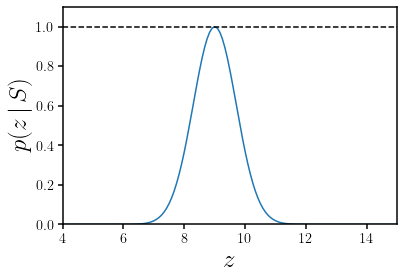

In [7]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
sub.plot(mock[:,0], prob_z)
sub.plot([0., 100], [1., 1.], c='k', ls='--')
sub.set_xlabel('$z$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylabel('$p(z\,|\,S)$', fontsize=25)
sub.set_ylim(0., 1.1)

(-14.0, -22.0)

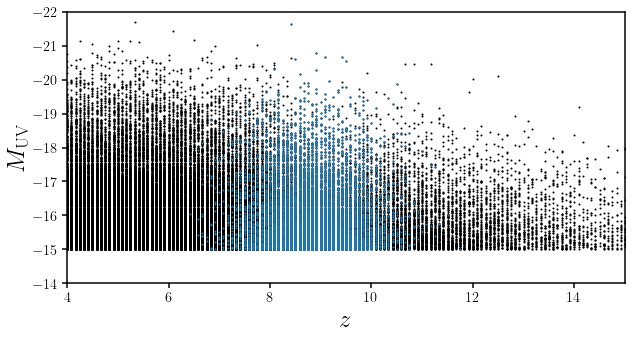

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1, c='k')
sub.scatter(mock[:,0][select_z], mock[:,1][select_z], s=1, c='C0')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

# implement $m_{\rm UV}$ cut 
on noisy apparent magnitude. This should be more analogous to the actual selection in observations

In [9]:
# convert mock absolute magnitude to apparent magnitudes
mock_muv = mock[:,1] + 5 * np.log10(Planck13.luminosity_distance(mock[:,0]).to(u.pc).value/10.)
mock_muv_noisy = mock_muv + 0.1*np.random.normal(size=len(mock_muv))

In [10]:
mock_Muv_noisy = mock_muv_noisy - 5 * np.log10(Planck13.luminosity_distance(mock[:,0]).to(u.pc).value/10.)

In [11]:
select_muv = (mock_muv_noisy < 32)
print(np.mean(select_z & select_muv))
print(np.sum(select_z & select_muv))

0.008652530276498375
588


In [14]:
unif_Muv = np.random.uniform(-22, -15, size=int(1e6))
unif_z = np.random.uniform(4., 15, size=int(1e6))
unif_muv = (unif_Muv + 5 * np.log10(Planck13.luminosity_distance(unif_z).to(u.pc).value/10.) 
            + 0.1*np.random.normal(size=int(1e6)))

unif_select_z = np.exp(-(unif_z - 9.0)**2) > np.random.uniform(size=int(1e6))
unif_select_muv = unif_muv < 32

(-15.0, -22.0)

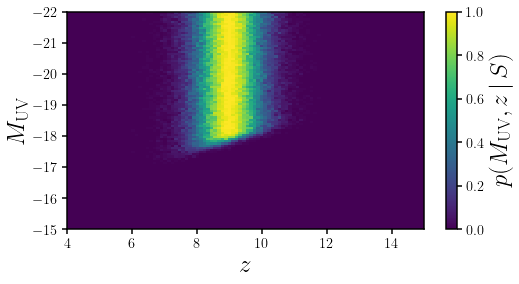

In [15]:
h, bx, by = np.histogram2d(unif_z, unif_Muv, bins=[100, 100], range=[(4, 15), (-22, -15)])
h_select, _, _ = np.histogram2d(unif_z[unif_select_z & unif_select_muv], unif_Muv[unif_select_z & unif_select_muv], 
                                bins=[100, 100], range=[(4, 15), (-22, -15)])

fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
X, Y = np.meshgrid(bx, by)
p = sub.pcolormesh(X, Y, (h_select/h).T, vmin=0., vmax=1)
plt.colorbar(p).set_label(r'$p(M_{\rm UV}, z\,|\,S)$', size=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_ylim(-15, -22)

### save randoms for selection function estimation

In [16]:
np.savetxt('/Users/chahah/data/binsin/mock0_selection.dat', 
           np.array([unif_z, unif_Muv, (unif_select_z & unif_select_muv).astype(int)]).T, header='z, Muv, select')

(-14.0, -22.0)

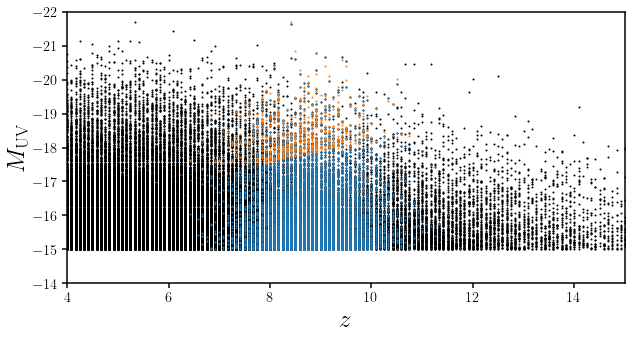

In [17]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1, c='k')
sub.scatter(mock[:,0][select_z], mock[:,1][select_z], s=1, c='C0')
sub.scatter(mock[:,0][select_z & select_muv], mock_Muv_noisy[select_z & select_muv], s=1, c='C1')

sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## add noise based on Finkelstein *et al.* (2023)
https://ui.adsabs.harvard.edu/abs/2023ApJ...946L..13F/abstract

In [18]:
ceers_z9 = np.loadtxt('/Users/chahah/data/binsin/ceers_S9_table.dat', skiprows=1)

(-14.0, -22.0)

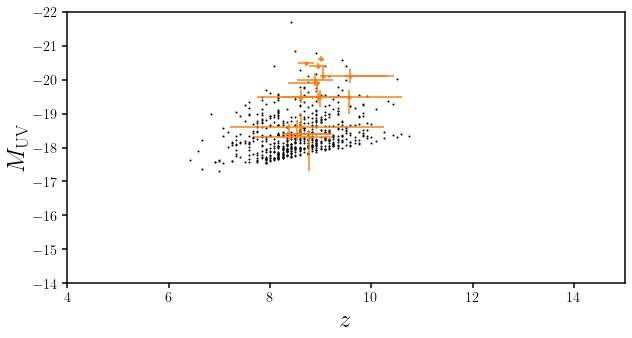

In [19]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0][select_z & select_muv], mock_Muv_noisy[select_z & select_muv], s=1, c='k')
sub.errorbar(ceers_z9[:,0], ceers_z9[:,3], 
             xerr=[ceers_z9[:,1], ceers_z9[:,2]], yerr=[ceers_z9[:,4], ceers_z9[:,5]], fmt='.C1')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

In [20]:
mock_Muv_1sig = 0.12 + 0.0*np.random.normal(size=mock.shape[0])

(-14.0, -22.0)

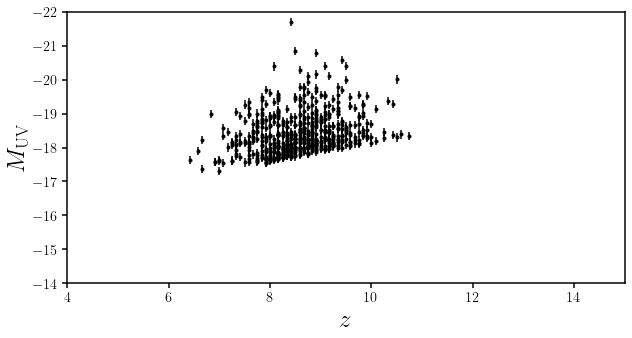

In [21]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.errorbar(mock[:,0][select_z & select_muv], mock_Muv_noisy[select_z & select_muv], 
             yerr=mock_Muv_1sig[select_z & select_muv], fmt='.k')

sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## lets add photo-$z$ noise

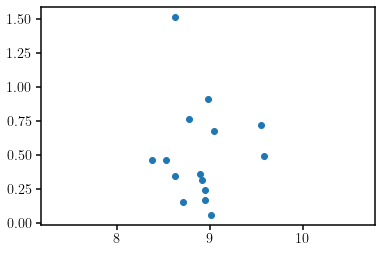

In [22]:
plt.scatter(ceers_z9[:,0], 0.5*(ceers_z9[:,1] + ceers_z9[:,2]))

error level of CEERS photo-zs

In [23]:
np.std(0.5*(ceers_z9[:,1] + ceers_z9[:,2]))

0.35837131581643084

(array([3., 3., 4., 0., 3., 1., 0., 0., 0., 1.]),
 array([0.06  , 0.2055, 0.351 , 0.4965, 0.642 , 0.7875, 0.933 , 1.0785,
        1.224 , 1.3695, 1.515 ]),
 <BarContainer object of 10 artists>)

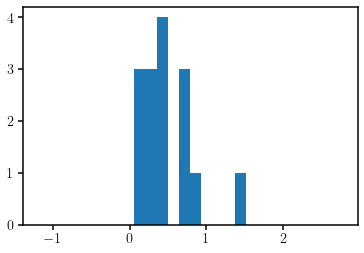

In [25]:
plt.hist(0.5*(ceers_z9[:,1] + ceers_z9[:,2]))

In [26]:
mock_photoz_1sig = (0.5 + 0.36 * np.random.normal(size=mock.shape[0])).clip(0.05, None) 

In [27]:
mock_photoz = mock[:,0] + mock_photoz_1sig * np.random.normal(size=mock.shape[0])

(-14.0, -22.0)

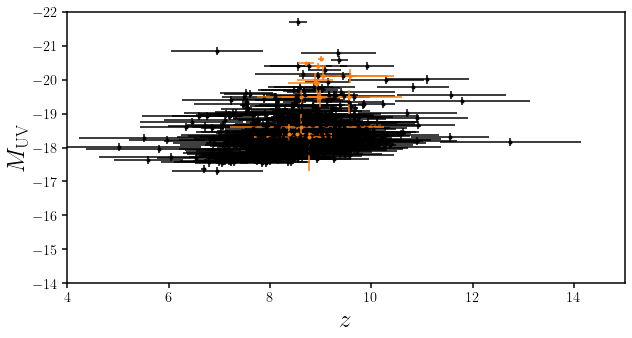

In [28]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.errorbar(mock_photoz[select_z & select_muv], mock_Muv_noisy[select_z & select_muv], 
             xerr=mock_photoz_1sig[select_z & select_muv], 
             yerr=mock_Muv_1sig[select_z & select_muv], fmt='.k')
sub.errorbar(ceers_z9[:,0], ceers_z9[:,3], 
             xerr=[ceers_z9[:,1], ceers_z9[:,2]], yerr=[ceers_z9[:,4], ceers_z9[:,5]], fmt='.C1')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## save mock0

In [29]:
np.savetxt('/Users/chahah/data/binsin/mock0.dat',
           np.array([mock_photoz[select_z & select_muv], 
                     mock_Muv_noisy[select_z & select_muv], 
                     mock_photoz_1sig[select_z & select_muv], 
                     mock_Muv_1sig[select_z & select_muv]]).T, header='z, Muv, sig_z, sig_Muv')

# why binning is sinning

(1, 400.0)

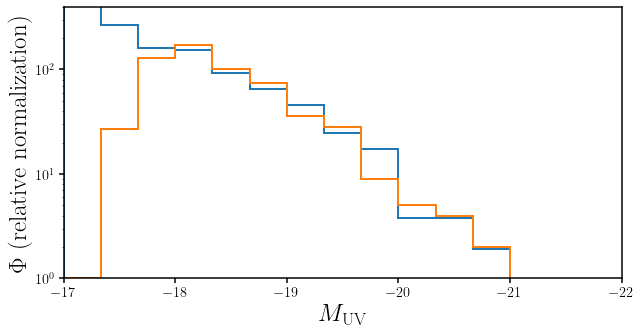

In [62]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

w = np.sum((mock[:,1] < -18.5) & select_z & select_muv)
w /= np.sum((mock[:,0] > 8.5) & (mock[:,0] < 9.5) & (mock[:,1] < -18.5))

_ = sub.hist(mock[:,1][(mock[:,0] > 8.5) & (mock[:,0] < 9.5)], 
             weights=np.repeat(w, np.sum((mock[:,0] > 8.5) & (mock[:,0] < 9.5))),
             range=(-21, -17), bins=12, histtype='step', linewidth=2)
_ = sub.hist(mock_Muv_noisy[select_z & select_muv], 
             range=(-21, -17), bins=12, histtype='step', linewidth=2)
sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(-17, -22)
sub.set_ylabel(r'$\Phi$ (relative normalization)', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1, 4e2)